In [11]:
import sys
import os
import csv
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from run_quicksort import execute_quicksort, get_times
from plot import plot_results

In [22]:
NUM_REPETITIONS = 20
ARRAY_SIZES = [str(i) for i in range(1000000, 10000001, 1000000)] 

In [18]:
def save_results_to_csv(results_data, filename):
    if not results_data:
        print(f"No data collected to save to {filename}.")
        return

    fieldnames = ['size', 'run', 'sequential_time', 'parallel_time', 'builtin_time']

    try:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(results_data)
        return True
    except Exception as e:
        print(f"\nERROR - Failed to save results to CSV: {e}")
        return False

In [19]:
def conduct_experiments(array_sizes, repetitions):
    all_results = []
    output_filename = "quicksort_results.csv"

    print(f"Starting Experiment: {repetitions} repetitions per array size.")
    print(f"Results will be saved to: {output_filename}")

    for size in array_sizes:
        for i in range(1, NUM_REPETITIONS+1):
            result = execute_quicksort(size)
            if result and result.returncode == 0:
                try:
                    sequential_time, parallel_time, builtin_time = get_times(result)
                    print(f" Success. Times (s/p/b): {sequential_time:.4f} / {parallel_time:.4f} / {builtin_time:.4f}")

                    all_results.append({
                        'size': size,
                        'run': i,
                        'sequential_time': sequential_time,
                        'parallel_time': parallel_time,
                        'builtin_time': builtin_time,
                    })
                except Exception as e:
                    print(f" ERROR: {e}")
            elif result is None:
                print(" FAILED ")
                # Save partial results before exiting
                save_results_to_csv(all_results, "quicksort_results_partial.csv")
                sys.exit(1)
            else:
                print(f" FAILED - Program returned non-zero code: {result.returncode}")


    if save_results_to_csv(all_results, output_filename):
        return output_filename
    else:
        return None

In [20]:
def plot_results(filename):
    try:
        df = pd.read_csv(filename)
        df['size'] = pd.to_numeric(df['size'])

        grouped = df.groupby('size')
        avg_times = grouped[['sequential_time', 'parallel_time', 'builtin_time']].mean()
        
        # Calculate 90% confidence intervals
        def calculate_ci(data):
            n = len(data)
            if n < 2:
                return 0
            sem = data.sem()  # Standard error of the mean
            return 1.645 * sem  # 90% ci
        
        seq_ci = grouped['sequential_time'].apply(calculate_ci)
        par_ci = grouped['parallel_time'].apply(calculate_ci)
        builtin_ci = grouped['builtin_time'].apply(calculate_ci)
        
        NUM_REPETITIONS = grouped.size().iloc[0]

        plt.figure(figsize=(6, 4))

        array_sizes = [int(x) for x in avg_times.index]

        # Plot with error bars for confidence intervals
        plt.errorbar(array_sizes, avg_times['sequential_time'], 
                    yerr=seq_ci.values, label='Sequential Quicksort',
                    marker='o', capsize=5, capthick=2, linestyle='-', linewidth=2)
        
        plt.errorbar(array_sizes, avg_times['parallel_time'], 
                    yerr=par_ci.values, label='Parallel Quicksort',
                    marker='s', capsize=5, capthick=2, linestyle='-', linewidth=2)
        
        plt.errorbar(array_sizes, avg_times['builtin_time'], 
                    yerr=builtin_ci.values, label='Built-in (Reference) Sort',
                    marker='^', capsize=5, capthick=2, linestyle='-', linewidth=2)

        # Formatting
        title_string = f'Quicksort Performance: Time vs. Array Size\n(Average of {NUM_REPETITIONS} runs with 95% Confidence Intervals)'
        plt.title(title_string, fontsize=14, pad=20)
        plt.xlabel('Array Size', fontsize=12)
        plt.ylabel('Average Execution Time (s)', fontsize=12)

        plt.grid(True, which="both", ls="--", alpha=0.6)
        plt.legend(fontsize=11)
        
        # Use log scale if data spans large ranges
        if max(array_sizes) / min(array_sizes) > 100:
            plt.xscale('log')
        max_time = max(avg_times['sequential_time'].max(), avg_times['parallel_time'].max(), avg_times['builtin_time'].max())
        min_time = min(avg_times['sequential_time'].min(), avg_times['parallel_time'].min(), avg_times['builtin_time'].min())
        if max_time / min_time > 100:
            plt.yscale('log')

        # Save the plot
        plot_filename = filename.replace('.csv', '_with_CI.png')
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"[SUCCESS] Plot saved to {plot_filename}")
        
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        import traceback
        traceback.print_exc()

Starting Experiment: 20 repetitions per array size.
Results will be saved to: quicksort_results.csv
The program ran successfully.
 Success. Times (s/p/b): 0.1718 / 0.4442 / 0.1430
The program ran successfully.
 Success. Times (s/p/b): 0.1363 / 0.4053 / 0.1399
The program ran successfully.
 Success. Times (s/p/b): 0.1333 / 0.4167 / 0.1359
The program ran successfully.
 Success. Times (s/p/b): 0.1457 / 0.4178 / 0.1428
The program ran successfully.
 Success. Times (s/p/b): 0.1336 / 0.4353 / 0.1351
The program ran successfully.
 Success. Times (s/p/b): 0.1373 / 0.3929 / 0.1443
The program ran successfully.
 Success. Times (s/p/b): 0.1363 / 0.4428 / 0.1429
The program ran successfully.
 Success. Times (s/p/b): 0.1745 / 0.6902 / 0.2223
The program ran successfully.
 Success. Times (s/p/b): 0.2267 / 0.7249 / 0.2207
The program ran successfully.
 Success. Times (s/p/b): 0.2120 / 0.7062 / 0.2195
The program ran successfully.
 Success. Times (s/p/b): 0.2625 / 0.6879 / 0.2307
The program ran succ

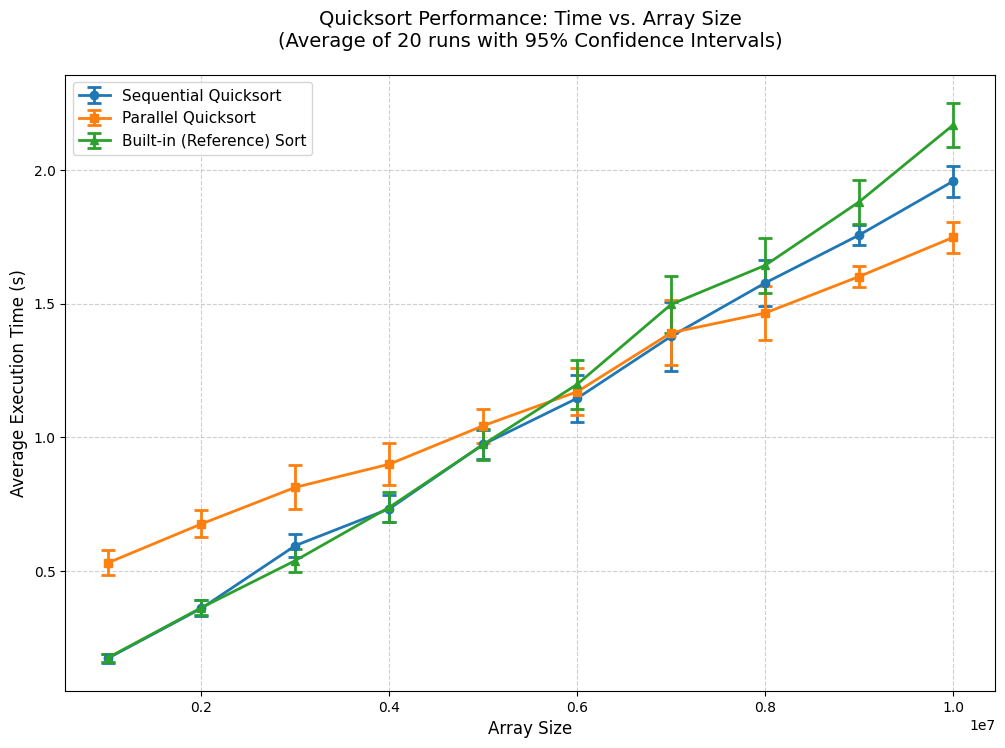

[SUCCESS] Plot with confidence intervals saved to quicksort_results_with_CI.png


In [21]:
final_csv_file = conduct_experiments(ARRAY_SIZES, NUM_REPETITIONS)

if final_csv_file:
    print(ARRAY_SIZES)
    print("Plotting...")
    plot_results(final_csv_file)

Starting Experiment: 20 repetitions per array size.
Results will be saved to: quicksort_results.csv
The program ran successfully.
 Success. Times (s/p/b): 0.0138 / 0.3716 / 0.0121
The program ran successfully.
 Success. Times (s/p/b): 0.0117 / 0.3281 / 0.0126
The program ran successfully.
 Success. Times (s/p/b): 0.0122 / 0.3309 / 0.0120
The program ran successfully.
 Success. Times (s/p/b): 0.0118 / 0.3512 / 0.0125
The program ran successfully.
 Success. Times (s/p/b): 0.0125 / 0.3740 / 0.0125
The program ran successfully.
 Success. Times (s/p/b): 0.0116 / 0.3855 / 0.0121
The program ran successfully.
 Success. Times (s/p/b): 0.0183 / 0.3764 / 0.0127
The program ran successfully.
 Success. Times (s/p/b): 0.0128 / 0.3757 / 0.0136
The program ran successfully.
 Success. Times (s/p/b): 0.0141 / 0.3358 / 0.0125
The program ran successfully.
 Success. Times (s/p/b): 0.0114 / 0.3526 / 0.0117
The program ran successfully.
 Success. Times (s/p/b): 0.0135 / 0.3358 / 0.0129
The program ran succ

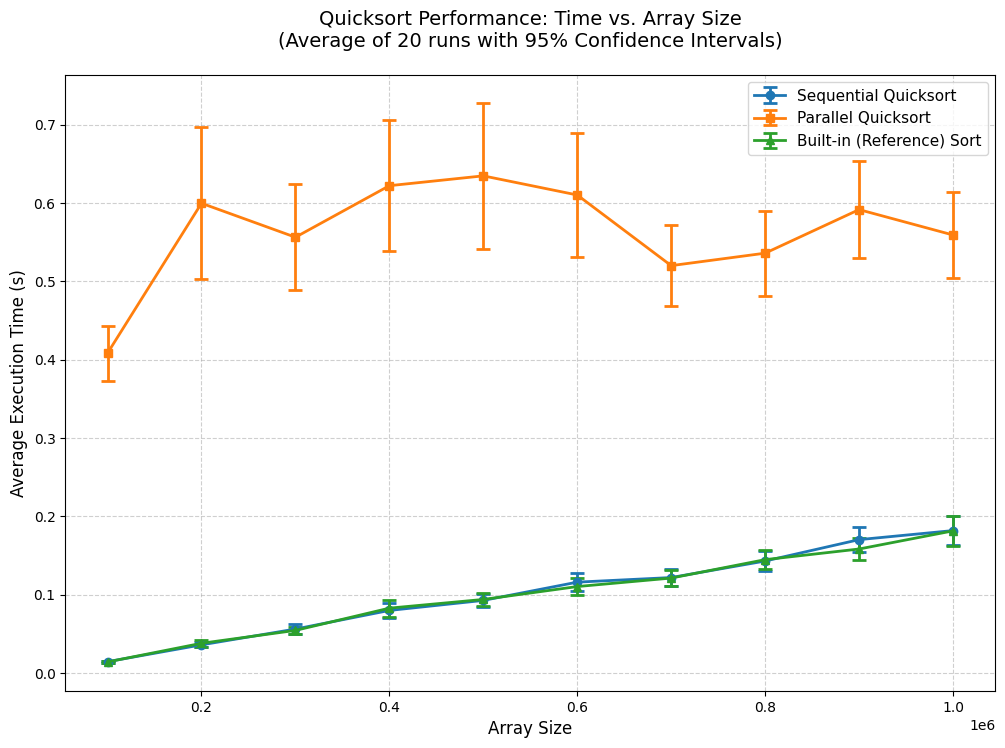

[SUCCESS] Plot with confidence intervals saved to quicksort_results_with_CI.png


In [23]:
ARRAY_SIZES = [str(i) for i in range(100000, 1000001, 100000)] 
NUM_REPETITIONS = 20
final_csv_file = conduct_experiments(ARRAY_SIZES, NUM_REPETITIONS)

if final_csv_file:
    print(ARRAY_SIZES)
    print("Plotting...")
    plot_results(final_csv_file)